<center><h1> PDE: Extension to Higher Dimensions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import distributions as dist
import dolfin as fin

In [2]:
from mud.plot import make_2d_unit_mesh
from mud.util import std_from_equipment

In [3]:
from experiments import mud_problem
from plotting import log_linear_regression, plot_experiment_measurements

In [4]:
from newpoisson import poisson, poisson_sensor_model
import pickle

In [5]:
from mud_problem import generate_sensors_pde, load_poisson

In [6]:
from experiments import experiment_measurements_index, extract_statistics_index
from plotting import log_linear_regression, plot_experiment_measurements

### Debugging: Implementation of Data-Driven Map

In [7]:
from scipy.stats import gaussian_kde as gkde

In [8]:
def ratio_dci(qoi):
    kde = gkde(qoi)
    ratio_eval = dist.norm.pdf(qoi)/kde.pdf(qoi)
    return ratio_eval

In [9]:
def meas_to_qoi(qoi, data, sd):
    if qoi.ndim == 1: qoi = qoi.reshape(1,-1)
    num_evals = qoi.shape[0]
    assert qoi.shape[1] == len(data)
    residuals = np.subtract(qoi, data)
    weighted_residuals = np.divide(residuals, sd)
    assert weighted_residuals.shape[0] == num_evals
    weighted_sum = np.sum(weighted_residuals, axis=1)
    return weighted_sum/np.sqrt(len(data))

In [10]:
def band_qoi(sensors, num_qoi=1, axis=1):
    intervals = np.linspace(0, 1, num_qoi+2)[1:-1]
    _intervals = np.array(intervals[1:]) + ( np.array(intervals[:-1]) - np.array(intervals[1:]) ) / 2
    _intervals = [0] + list(_intervals) + [1]
    qoi_indices = [np.where(np.logical_and(sensors[:, axis] > _intervals[i],
                                           sensors[:, axis] < _intervals[i+1]))[0] for i in range(num_qoi) ]
    return qoi_indices


def split_qoi_by_indices(qoi_indices, qoi_true, qoi, noise, sigma, first=None):
    qois = []
    if first is None: first = qoi.shape[1]
    for i in range(0, len(qoi_indices)):
        q = qoi_indices[i][qoi_indices[i] < first]
    #     q = qoi_indices[i]
        
        _qoi = qoi[:, q]
        _noise = noise[q]
        _data = np.array(qoi_true)[q] + _noise

        _newqoi = meas_to_qoi(_qoi, _data , sigma)
        qois.append(_newqoi)
    return qois


def ratio_dci_mult(qois):
    nq = np.array(qois)
    kde = gkde(nq)
    obs = dist.norm.pdf(nq)
    obs_eval = np.product(obs, axis=0)
    ratio_eval = np.divide(obs_eval, kde.pdf(nq))
    return ratio_eval

# Settings

In [11]:
from newpoisson import pcwExpr, pcwGFun

In [12]:
prefix      = f'pde-highd/pde-highd'
num_measure = 100 # number of measurement (sensor) locations
fsize       = 32
num_trials  = 20   # realizations of synthetic data for numerical runs
tolerance   = 0.1 # precision of measurement equipment
sigma       = std_from_equipment(tolerance=tolerance, probability=0.99)
np.random.seed(21)
lam_true    = 3.0
input_dim   = 2
num_samples = 1000
ftype       = 'png'

In [13]:
load = True
measurements = [20, 40, 60, 80, 100]
# tolerances = [1E-1, 1E-2, 1E-3]
print(f"Will run simulations for {measurements}")

Will run simulations for [20, 40, 60, 80, 100]


In [14]:
u = fin.Expression("-gamma*sin((2*kappa+1)*pi*x[0])", gamma=3.0, kappa=0.0, degree=3)
u = fin.Expression(f"pow(x[0], 2) * pow(x[0] - 1, 5) * gamma", gamma=lam_true*823543/12500, degree=3)
mesh = fin.UnitIntervalMesh(100)

def getVals(u,n):
    dx=1/(n+1)
    invals = [i*dx for i in range(n+2)]
    outvals = [u(i) for i in invals][1:-1]
    return invals[1:-1], outvals

def expressionNorm(u,v,n=100):
    u = getVals(u, n)[1] 
    v = getVals(v, n)[1]
    return np.linalg.norm(np.array(u) - np.array(v))/n

In [15]:
model_dict = {}
for _input_dim in [2, 5, 11]:
    model_dict[_input_dim] = pickle.load(open(f'res{_input_dim}u.pkl', 'rb'))

# Define Sensors

In [16]:
sensors = generate_sensors_pde(num_measure)

In [17]:
qoi_true = poisson_sensor_model(sensors, gamma=lam_true, nx=36, ny=36)
noise = sigma*np.random.randn(num_measure)

### Visualize

In [18]:
p = poisson(gamma=lam_true, nx=36, ny=36)
V = p.function_space()

In [19]:
svals = [p(xi,yi) for xi,yi in sensors]

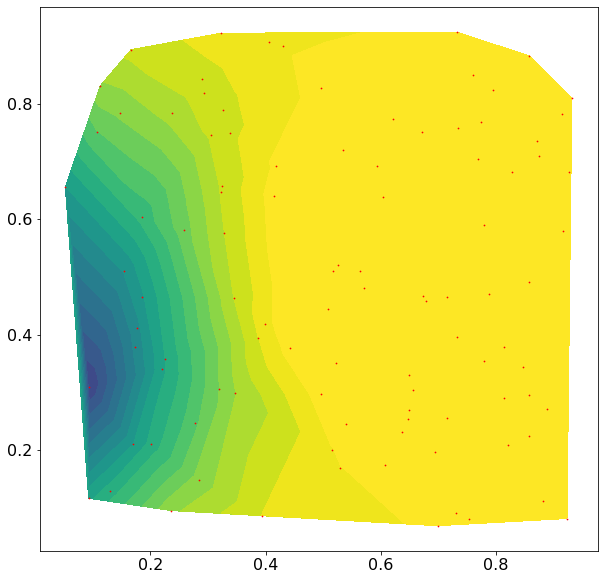

In [20]:
z = svals
x, y = sensors[:,0], sensors[:,1]
plt.tricontourf(x, y, z, levels=20, vmin=-0.5, vmax=0)
plt.scatter(x, y, c='r', s=0.5)
plt.show()

 ---

---

## Simulate Perturbed Response Surface

$\tau$ was specified in the cells above using `tolerance`, take a look at your possible data and determine if it is reasonable before proceeding.

In [21]:
pn = poisson(gamma=lam_true)
v = np.array(pn.vector())
# v = p.compute_vertex_values()
pn.vector()[:] = v + sigma*np.random.randn(len(v))

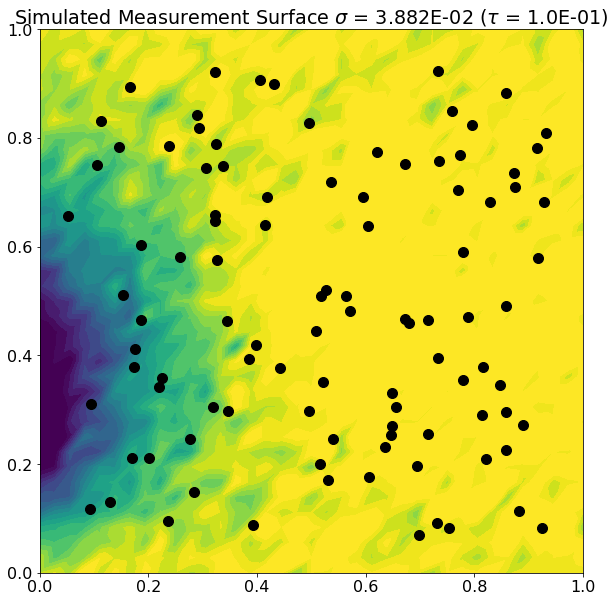

In [22]:
fin.plot(pn, vmin=-0.5, vmax=0)
plt.title(f"Simulated Measurement Surface $\\sigma$ = {sigma:1.3E} ($\\tau$ = {tolerance:1.1E})")
plt.scatter(sensors[0:100,0], sensors[0:100,1], s=100, c='k')
plt.show()

In [23]:
# %%time
# model_list = model_dict[input_dim]
# lam, qoi = load_poisson(sensors, model_list, nx=36, ny=36)

In [24]:
# domain = np.array([[-4,0]*input_dim]).reshape(-1,2)


In [25]:
intervals, gamma_true = getVals(u, input_dim)
w = fin.Expression(pcwExpr(u, input_dim, d=0), degree=2)
domain = np.array([[-4,0]*input_dim]).reshape(-1,2)
model_list = model_dict[input_dim]

In [26]:
# %%time
if load:
    fname = f'{prefix}_summary_{input_dim}.pkl'
    results = pickle.load(open(fname, 'rb'))
    solutions_sing, solutions_mult = results['sols']
    measurements = results['meas']
    noise, tolerance = results['noise']
    sigma = results['stdv']
    lam, qoi = results['sets']
    gamma_true, qoi_true = results['true']
    sensors = results['sens']
else:
    lam, qoi = load_poisson(sensors, model_list[0:num_samples], nx=36, ny=36)

## Best Case Scenario: Minimizing 2-Norms with Knowledge of Truth
minimizing norm of difference between "truth" and our samples, both input and output.

In [27]:
# %%time
closest_fit_index_in = np.argmin(np.linalg.norm(lam - np.array(gamma_true),axis=1))
closest_fit_index_out = np.argmin(np.linalg.norm(qoi - np.array(qoi_true) - noise,axis=1))

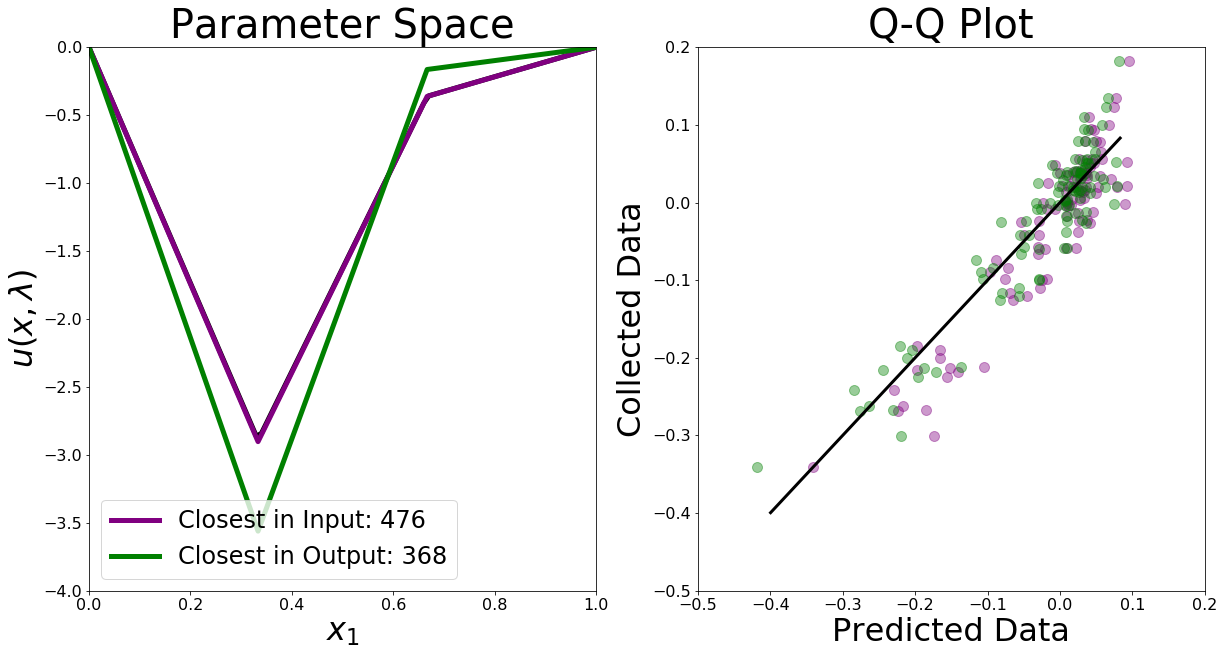

In [28]:
plt.figure(figsize=(20,10))
plt.subplot(121)
fin.plot(w, mesh=mesh, lw=5, c='k')
gt = list(lam[closest_fit_index_in, :])
plt.plot([0]+intervals+[1], [0]+gt+[0], lw=5, c='purple', alpha=1, label=f'Closest in Input: {closest_fit_index_in}')

projected_line = list(lam[closest_fit_index_out, :])
plt.plot([0]+intervals+[1], [0]+projected_line+[0], lw=5, c='green', alpha=1, label=f'Closest in Output: {closest_fit_index_out}')

plt.legend(fontsize=fsize*0.75)
plt.title(f'Parameter Space', fontsize=fsize*1.25)
plt.ylim(-4, 0)
plt.xlim(0, 1)
plt.ylabel('$u(x, \lambda)$', fontsize=fsize)
plt.xlabel('$x_1$', fontsize=fsize)

plt.subplot(122)
_plot_num = max(measurements)
q = qoi[closest_fit_index_in,:]
plt.scatter(q[:_plot_num], qoi_true[:_plot_num] + noise[:_plot_num], c='purple', s=100, alpha=0.4, label=f'Closest in Input: {closest_fit_index_in}')
q = qoi[closest_fit_index_out,:]
plt.scatter(q[:_plot_num], qoi_true[:_plot_num] + noise[:_plot_num], c='green', s=100, alpha=0.4, label=f'Closest in Output: {closest_fit_index_out}')

_a = np.linspace(min(qoi_true),max(qoi_true), 2)
plt.plot(_a,_a, c='k', lw=3)
plt.xlim(-0.5, 0.2)
plt.ylim(-0.5, 0.2)
# plt.legend(fontsize=fsize)
plt.xlabel('Predicted Data', fontsize=fsize)
plt.ylabel('Collected Data', fontsize=fsize)
plt.title("Q-Q Plot", fontsize=fsize*1.25)

_fname = f"{prefix}_proj_D{input_dim}.{ftype}"
plt.savefig(_fname, bbox_inches='tight')
plt.show()

---

In [29]:
num_qoi = input_dim
# plot_qoi = [20, 100, 500, 1000][::-1]
plot_qoi = measurements[::-2]
qoi_indices     = band_qoi(sensors, num_qoi, axis=1)
qoi_indices_bad = band_qoi(sensors, num_qoi, axis=0)
colors = ['xkcd:red', 'xkcd:black', 'xkcd:orange', 'xkcd:blue', 'xkcd:green']

In [30]:
_intervals = np.array(intervals[1:]) + ( np.array(intervals[:-1]) - np.array(intervals[1:]) ) / 2

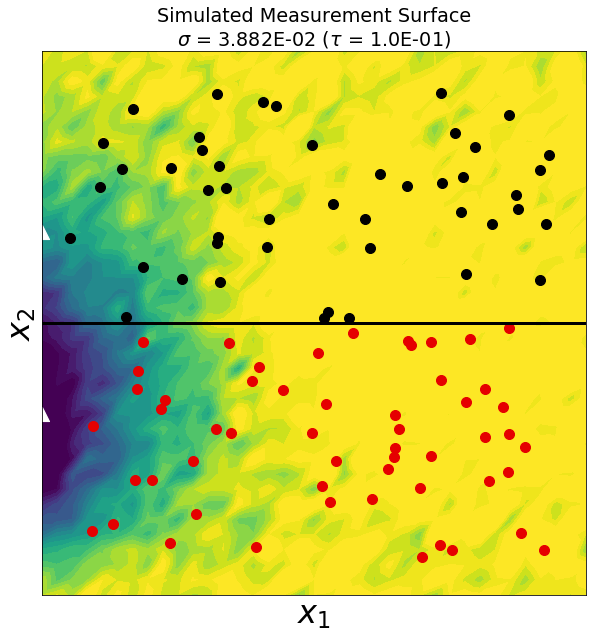

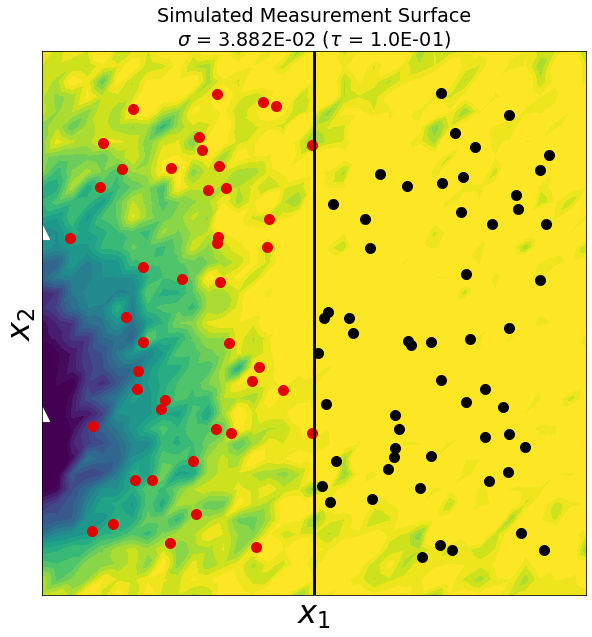

In [31]:
plt.figure(figsize=(10,10))
fin.plot(pn, vmin=-0.5, vmax=0)
plt.title(f"Simulated Measurement Surface\n$\\sigma$ = {sigma:1.3E} ($\\tau$ = {tolerance:1.1E})")
for i in range(0, num_qoi):
    if i < num_qoi - 1: plt.axhline(_intervals[i], lw=3, c='k')
    _q = qoi_indices[i][qoi_indices[i] < 100 ]
    plt.scatter(sensors[_q,0], sensors[_q,1], s=100, color=colors[i%2])
plt.scatter([0]*input_dim, intervals, s=200, marker='^', c='w')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([])
plt.yticks([])
plt.xlabel("$x_1$", fontsize=fsize)
plt.ylabel("$x_2$", fontsize=fsize)

_fname = f"{prefix}_sensors_D{input_dim}.{ftype}"
plt.savefig(_fname, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,10))
fin.plot(pn, vmin=-0.5, vmax=0)
plt.title(f"Simulated Measurement Surface\n$\\sigma$ = {sigma:1.3E} ($\\tau$ = {tolerance:1.1E})")
for i in range(0, num_qoi):
    if i < num_qoi - 1: plt.axvline(_intervals[i], lw=3, c='k')
    _q = qoi_indices_bad[i][qoi_indices_bad[i] < 100 ]
    plt.scatter(sensors[_q,0], sensors[_q,1], s=100, color=colors[i%2])
plt.scatter([0]*input_dim,intervals, s=200, marker='^', c='w')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([])
plt.yticks([])
plt.xlabel("$x_1$", fontsize=fsize)
plt.ylabel("$x_2$", fontsize=fsize)

_fname = f"{prefix}_sensors-alt_D{input_dim}.{ftype}"
plt.savefig(_fname, bbox_inches='tight')
plt.show()

# Geometry Study

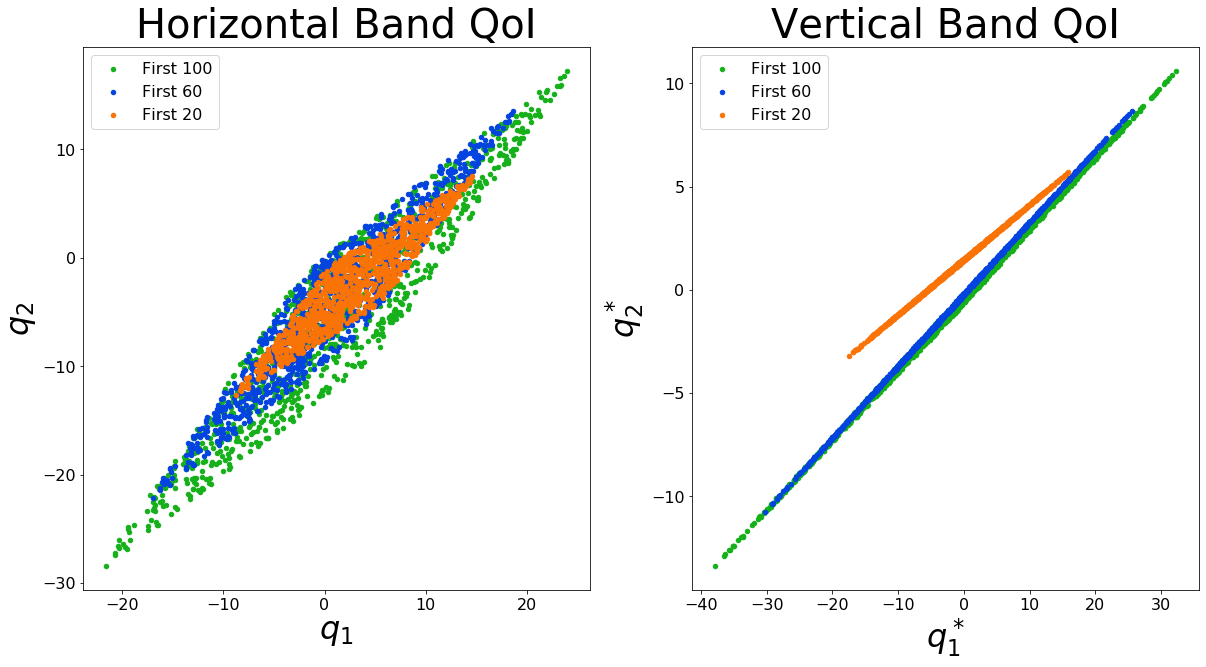

In [32]:
if input_dim == 2:
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    colors = ['xkcd:red', 'xkcd:black', 'xkcd:orange', 'xkcd:blue', 'xkcd:green'][::-1]
#     plot_qoi = [20, 100, 500, 1000][::-1]
    for idx, _first in enumerate(plot_qoi):
        qois = split_qoi_by_indices(qoi_indices, qoi_true, qoi, noise, sigma, first=_first)
        plt.scatter(qois[0], qois[1], label=f'First {_first}', s=20, c=colors[idx], alpha=1)
    plt.legend()
    plt.title("Horizontal Band QoI", fontsize=1.25*fsize)
    plt.xlabel("$q_1$", fontsize=fsize)
    plt.ylabel("$q_2$", fontsize=fsize)
    
    plt.subplot(122)
    for idx, _first in enumerate(plot_qoi):
        qois = split_qoi_by_indices(qoi_indices_bad, qoi_true, qoi, noise, sigma, first=_first)
        plt.scatter(qois[0], qois[1], label=f'First {_first}', s=20, c=colors[idx], alpha=1)
    plt.legend()
    plt.title("Vertical Band QoI", fontsize=1.25*fsize)
    plt.xlabel("$q^*_1$", fontsize=fsize)
    plt.ylabel("$q^*_2$", fontsize=fsize)

else:
    plt.figure(figsize=(20,20))
#     lim = 7.5/tolerance
    lim = 3/tolerance
    fig, axs = plt.subplots(input_dim, input_dim, figsize=(20,20))
    for _i in range(input_dim):
        for _j in range(_i, input_dim):
            if _i == _j:
                ax = axs[_i][_i]

                ax.annotate(f"$q{_i+1}$", (-lim/10,0), fontsize=fsize)
    #             ax.set_ylabel(f"$q{_i+1}$")
    #             ax.set_xlabel(f"$q{_i+1}$")
                ax.set_xlim(-lim, lim)
                ax.set_ylim(-lim, lim)
    #             ax.set_xticks([])
    #             ax.set_yticks([])
            else:
                for idx, _first in enumerate(plot_qoi):
                    ax = axs[_i][_j]
                    qois = split_qoi_by_indices(qoi_indices, qoi_true, qoi, noise, sigma, first=_first)
                    ax.scatter(qois[_i], qois[_j], label=f'First {_first}', s=20, c=colors[idx], alpha=1)
                    ax.set_xlim(-lim, lim)
                    ax.set_ylim(-lim, lim)
                    ax.set_xticks([])
                    ax.set_yticks([])

                    ax = axs[_j][_i]
                    qois = split_qoi_by_indices(qoi_indices_bad, qoi_true, qoi, noise, sigma, first=_first)
                    ax.scatter(qois[_i], qois[_j], label=f'First {_first}', s=20, c=colors[idx], alpha=1)
                    ax.set_xlim(-lim, lim)
                    ax.set_ylim(-lim, lim)
                    ax.set_xticks([])
                    ax.set_yticks([])

_fname = f"{prefix}_geom_D{input_dim}.{ftype}"
plt.savefig(_fname, bbox_inches='tight')
plt.show()    

# POC: Solve Inverse Problem

### Single QoI

In [33]:
# noise = np.random.randn(num_measure)*sigma
num_samps_ex_sol = 100

In [34]:
%%time
newqoi = meas_to_qoi(qoi[:,0:num_samps_ex_sol], qoi_true[0:num_samps_ex_sol] + noise[0:num_samps_ex_sol], sigma)
r_sing = ratio_dci(newqoi)

CPU times: user 55.2 ms, sys: 0 ns, total: 55.2 ms
Wall time: 54.7 ms


In [35]:
mud_idx = np.argmax(r_sing)
mud_fun = lam[mud_idx,:]
print(mud_idx)

839


### Multiple QoI

In [36]:
%%time
qois = split_qoi_by_indices(qoi_indices, qoi_true, qoi, noise, sigma, first=num_samps_ex_sol)
r_mult = ratio_dci_mult(qois)

CPU times: user 61.4 ms, sys: 165 µs, total: 61.5 ms
Wall time: 61.2 ms


In [37]:
mud_idx_mult = np.argmax(r_mult)
mud_fun_mult = lam[mud_idx_mult,:]

In [38]:
mud_idx_mult

334

## Compare Vector-Valued and Scalar Example Solutions

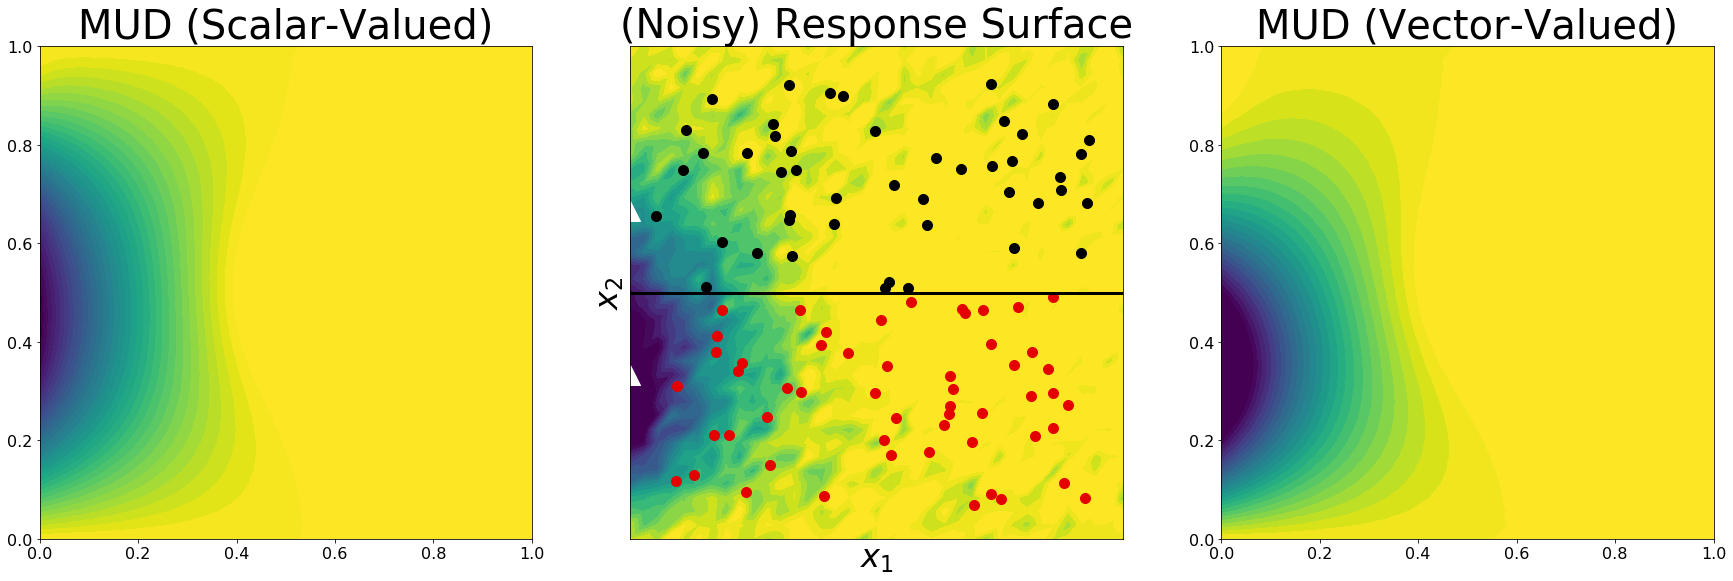

In [39]:
plt.figure(figsize=(30,10))
colors = ['xkcd:red', 'xkcd:black', 'xkcd:orange', 'xkcd:blue', 'xkcd:green']
plt.subplot(131)
fin.plot(poisson(mud_fun, nx=36,ny=36), vmin=-0.5, vmax=0)
plt.title('MUD (Scalar-Valued)', fontsize=1.25*fsize)

plt.subplot(132)
fin.plot(pn, vmin=-0.5, vmax=0)
plt.title('(Noisy) Response Surface', fontsize=1.25*fsize)
for i in range(0, num_qoi):
    if i < num_qoi - 1: plt.axhline(_intervals[i], lw=3, c='k')
    _q = qoi_indices[i][qoi_indices[i] < 100 ]
    plt.scatter(sensors[_q,0], sensors[_q,1], s=100, color=colors[i%2])
plt.scatter([0]*input_dim, intervals, s=400, marker='^', c='w')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([])
plt.yticks([])
plt.xlabel("$x_1$", fontsize=fsize)
plt.ylabel("$x_2$", fontsize=fsize)

plt.subplot(133)
fin.plot(poisson(mud_fun_mult, nx=36,ny=36), vmin=-0.5, vmax=0)
plt.title('MUD (Vector-Valued)', fontsize=1.25*fsize)

_fname = f"{prefix}_surf_exmud_D{input_dim}_m{num_samps_ex_sol}.{ftype}"
plt.savefig(_fname, bbox_inches='tight')
plt.show()


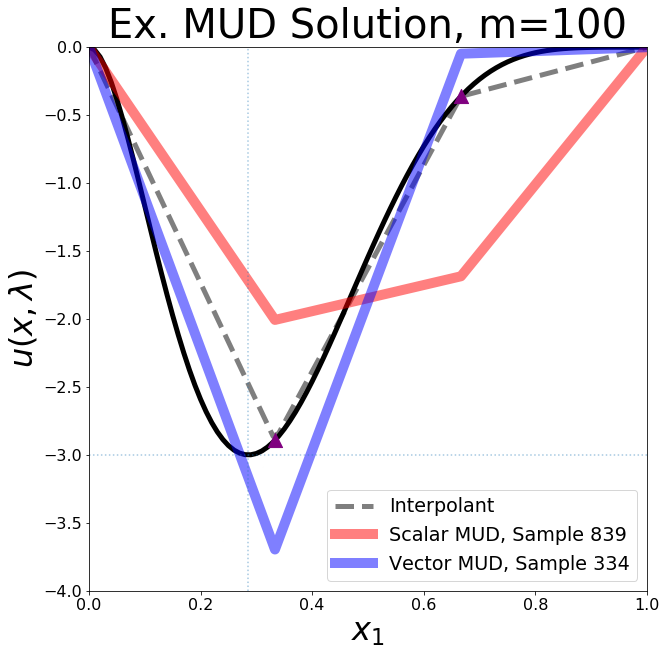

In [40]:
plt.figure(figsize=(10,10))

plt.subplot(111)
fin.plot(u, mesh=mesh, lw=5, c='k')
fin.plot(w, mesh=mesh, lw=5, c='k', ls='--', alpha=0.5, label='Interpolant')
# fin.plot(w, mesh=mesh, lw=10, c='r', ls='-', alpha=0.5)
plt.scatter(intervals, gamma_true, marker='^', s=200, c='purple', zorder=10)
plt.title(f'Ex. MUD Solution, m={num_samps_ex_sol}', fontsize=1.25*fsize)

plt.plot(np.linspace(0,1,input_dim+2),
            [0] + list(mud_fun) + [0],
            alpha=0.5, c='r', lw=10, label=f'Scalar MUD, Sample {mud_idx}')

plt.plot(np.linspace(0,1,input_dim+2),
            [0] + list(mud_fun_mult) + [0],
            alpha=0.5, c='b', lw=10, label=f'Vector MUD, Sample {mud_idx_mult}')

plt.axvline(2/7, alpha=0.4, ls=':')
plt.axhline(-lam_true, alpha=0.4, ls=':')
plt.ylim(-4,0)
plt.xlim(0,1)
plt.ylabel('$u(x, \lambda)$', fontsize=fsize)
plt.xlabel('$x_1$', fontsize=fsize)
plt.legend(fontsize=fsize*0.6, loc='lower right')

# plt.subplot(122)
# _data = qoi_true[:num_samps_ex_sol] + noise[:num_samps_ex_sol]
# plt.scatter(qoi[mud_idx,:num_samps_ex_sol], _data, c='r', s=100, alpha=0.4, label=f'Scalar MUD, Sample {mud_idx}')
# plt.scatter(qoi[mud_idx_mult,:num_samps_ex_sol], _data, c='b', s=100, alpha=0.4, label=f'Vector MUD, Sample {mud_idx_mult}')

# _a = np.linspace(min(qoi_true) ,max(qoi_true), 2)
# plt.plot(_a,_a, c='k', lw=3)
# plt.xlim(-0.5, 0.2)
# plt.ylim(-0.5, 0.2)
# plt.xlabel('Predicted Data', fontsize=fsize)
# plt.ylabel('Collected Data', fontsize=fsize)
# plt.title("Q-Q Plot", fontsize=fsize*1.25)
# plt.legend()


_fname = f"{prefix}_comp_exmud_D{input_dim}_m{num_samps_ex_sol}.{ftype}"
plt.savefig(_fname, bbox_inches='tight')
plt.show()

In [41]:
print(gamma_true)

[-2.892002853223595, -0.3615003566529494]


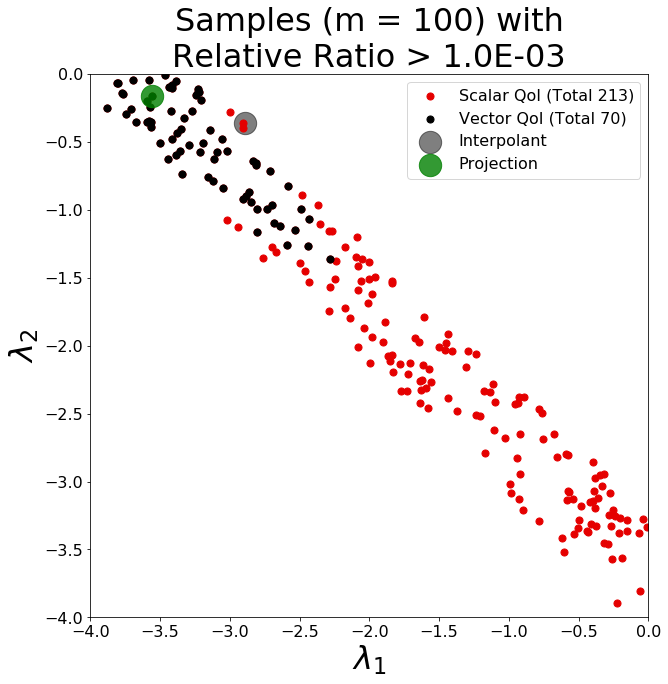

In [42]:
labels = ['Scalar QoI', 'Vector QoI']
plot_top = 1000
thresh = lam.shape[0]**-1
# thresh = 1E-16
colors = ['xkcd:red', 'xkcd:black', 'xkcd:orange', 'xkcd:blue', 'xkcd:green']

if input_dim == 2:
    for _i in range(input_dim):
        for _j in range(_i+1, input_dim):
            for idx, ratio_eval in enumerate([r_sing, r_mult]):
                _m = np.where(ratio_eval/max(ratio_eval) > thresh)[0]
#                 plt.scatter(lam[_m[101:5000], _i], lam[_m[101:5000], _j], c='orange', marker='^', alpha=0.2)
#                 plt.scatter(lam[_m[plot_top+1:1000], _i], lam[_m[plot_top+1:1000], _j], c='orange', marker='^', alpha=0.2)
                plt.scatter(lam[_m[:plot_top], _i], lam[_m[:plot_top], _j], c=colors[idx], label= labels[idx] + ' (Total %d)'%len(_m), s=50)
            plt.xlabel(f"$\lambda_{_i+1}$", fontsize=fsize)
            plt.ylabel(f"$\lambda_{_j+1}$", fontsize=fsize)
            plt.ylim(-4,0)
            plt.xlim(-4,0)
            plt.scatter(gamma_true[_i], gamma_true[_j], c='k', s=500, alpha=0.5, label='Interpolant', zorder=-10)
            plt.scatter(lam[closest_fit_index_out, _i], lam[closest_fit_index_out, _j], c='g', s=500, alpha=0.8, label='Projection', zorder=15)
            plt.legend()
            plt.title(f"Samples (m = {num_samps_ex_sol}) with\nRelative Ratio > {thresh:1.1E}", fontsize=fsize)

else:

    fig, axs = plt.subplots(input_dim, input_dim, figsize=(20,20))
    for _i in range(input_dim):
        for _j in range(_i, input_dim):
            if _i != _j:
                for idx, ratio_eval in enumerate([r_sing, r_mult]):
                    ax = axs[_j][_i] if not idx else axs[_i][_j]
                    _m = np.where(ratio_eval/max(ratio_eval) > thresh)[0]
                    ax.scatter(lam[_m[:plot_top], _i], lam[_m[:plot_top], _j], c=colors[2+idx], label= str(len(_m)) + ' ' + labels[idx], s=10)


    #                 ax.set_xlabel(f"$\lambda_{_i+1}$")
    #                 ax.set_ylabel(f"$\lambda_{_j+1}$")
                    ax.set_ylim(-4,0)
                    ax.set_xlim(-4,0)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    ax.scatter(gamma_true[_i], gamma_true[_j], c='k', s=250, alpha=1, label='Interpolant', zorder=-10)
                    ax.scatter(lam[closest_fit_index_out, _i], lam[closest_fit_index_out, _j], c='g', s=400, alpha=0.5, label='Projection', zorder=-10)
    #                 ax.legend()
            else:
                ax = axs[_i][_i]
                ax.annotate(f"$\lambda_{_i+1}$", (-0.6,0.5), fontsize=fsize)
#                 ax.set_xlabel(f"$\lambda_{_i+1}$", fontsize=fsize)
#                 ax.set_ylabel(f"$\lambda_{_i+1}$", fontsize=fsize)

                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_xlim(-1,0)


_fname = f"{prefix}_update_scatter_D{input_dim}_t{thresh:1.1E}".replace('.', '-') + f".{ftype}"
plt.savefig(_fname, bbox_inches='tight')
plt.show()

## Set Up Experiments

In [43]:
%%time
if input_dim == 11: measurements = [60, 80, 100]

if not load:
    # SCALAR
    def mud_wrapper(num_obs, sd):
        newqoi = meas_to_qoi(qoi=qoi[:,0:num_obs], data=qoi_true[0:num_obs] + np.random.randn(num_obs)*sd, sd=sd)
        r_sing = ratio_dci(newqoi)
        return r_sing

    experiments_sing, solutions_sing = experiment_measurements_index(num_measurements=measurements,
                                         sd=sigma,
                                         num_trials=num_trials,
                                         seed=21,
                                         fun=mud_wrapper)
    # VECTOR
    def mud_wrapper(num_obs, sd):
        qois = split_qoi_by_indices(qoi_indices, qoi_true, qoi,
                                    noise=np.random.randn(num_obs)*sd, sigma=sd, first=num_obs)
        r_mult = ratio_dci_mult(qois)
        return r_mult
    
    experiments_mult, solutions_mult = experiment_measurements_index(num_measurements=measurements,
                                         sd=sigma,
                                         num_trials=num_trials,
                                         seed=21,
                                         fun=mud_wrapper)
    
    del mud_wrapper

CPU times: user 691 µs, sys: 71 µs, total: 762 µs
Wall time: 19.1 µs


---

# The Story in Prediction Space

In [44]:
if num_qoi == 1:
    solutions = solutions_sing
else:
    solutions = solutions_mult

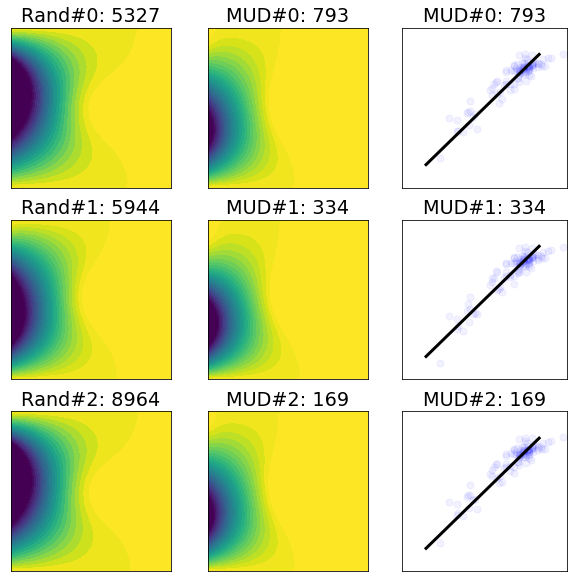

In [45]:
np.random.seed(21)
num_draws = 3
for idx in range(num_draws):
    i = np.random.randint(0,len(model_list))
    mudU = fin.Function(V, model_list[i][i]['u'])
    plt.subplot(int(f'{num_draws}{3}{1+3*idx}'))
    fin.plot(mudU, vmin=-0.5, vmax=0)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Rand#{idx}: {i}")
# plt.show()

num_plot_sensors = max(measurements)
for idx in range(num_draws):
#     _r = np.random.randint(0, num_trials)
    _r = idx
    i = solutions[num_plot_sensors][_r]
    mudU = fin.Function(V, model_list[i][i]['u'])
    plt.subplot(int(f'{num_draws}{3}{2+3*idx}'))
    fin.plot(mudU, vmin=-0.5, vmax=0)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"MUD#{idx}: {i}")

    q = qoi[i,:]
    plt.subplot(int(f'{num_draws}{3}{3+3*idx}'))
    plt.scatter(qoi_true + noise, q, c='b', s=50, alpha=0.05)
    plt.plot(_a,_a, c='k', lw=3)
#     plt.xlabel('True QoI (Noiseless)')
#     plt.ylabel('Predicted Signal')
    plt.xticks([])
    plt.yticks([])
    plt.xlim(-0.5, 0.2)
    plt.ylim(-0.5, 0.2)
    plt.title(f"MUD#{idx}: {i}")

plt.show()

# p = poisson(3.0)
# fin.plot(p, mesh=mesh, vmin=-0.5, vmax=0)
# plt.title("True (Noiseless) Repsonse Surface")
# plt.show()

# The Story in Parameter Space

In [46]:
from matplotlib import cm

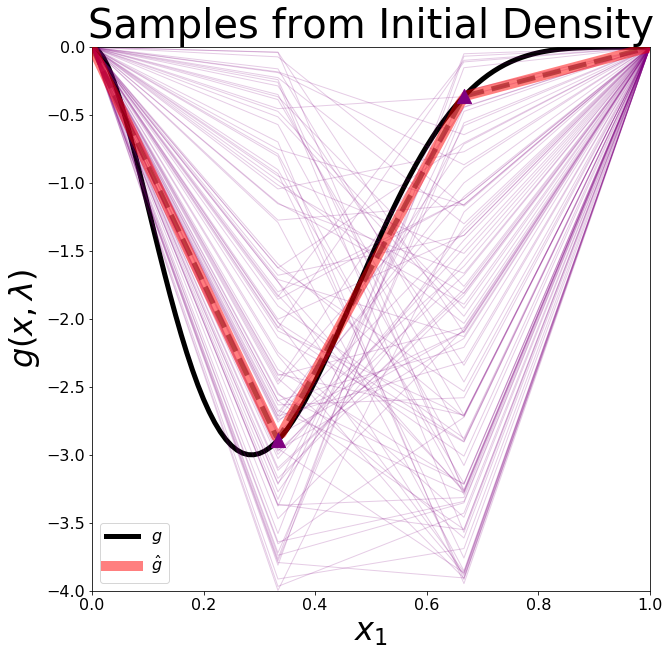

In [47]:
plt.figure(figsize=(10,10))

fin.plot(u, mesh=mesh, lw=5, c='k', label="$g$")
fin.plot(w, mesh=mesh, lw=5, c='k', ls='--', alpha=0.5, zorder=0)
fin.plot(w, mesh=mesh, lw=10, c='r', ls='-', alpha=0.5, label="$\hat{g}$", zorder=5)
plt.scatter(intervals, gamma_true, marker='^', s=200, c='purple', zorder=10)
# plt.plot([0]+intervals+[1], [0]+projected_line+[0], lw=5, c='green', alpha=1, label="$Proj_{g}$")


for i in range(100):
    gt = lam[i,:]
    plt.plot([0]+intervals+[1], [0]+list(gt)+[0], lw=1, c='purple', alpha=0.2)
plt.title('Samples from Initial Density', fontsize=1.25*fsize)
plt.xlabel("$x_1$", fontsize=fsize)
plt.ylabel("$g(x, \lambda)$", fontsize=fsize)




# plt.axvline(2/7, alpha=0.4, ls=':')
# plt.axhline(-lam_true, alpha=0.4, ls=':')
plt.ylim(-4,0)
plt.xlim(0,1)
plt.legend()

_fname = f"{prefix}_init_D{input_dim}.{ftype}"
plt.savefig(_fname, bbox_inches='tight')
plt.show()

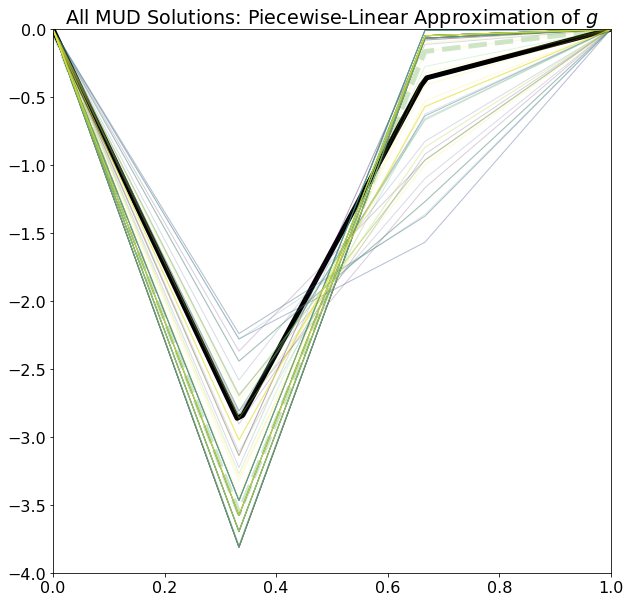

In [48]:
fin.plot(w, mesh=mesh, lw=5, c='k')
colors = cm.viridis(np.linspace(0,1,len(solutions)))
for i, ns in enumerate(solutions):
    for gt in solutions[ns]:
        plt.plot([0]+intervals+[1], [0]+list(lam[gt,:])+[0], lw=1, c=colors[i], alpha=0.2)
plt.title('All MUD Solutions: Piecewise-Linear Approximation of $g$')
plt.ylim(-4, 0)
plt.xlim(0, 1)
gt = list(lam[closest_fit_index_out, :])
plt.plot([0]+intervals+[1], [0]+gt+[0], lw=5, c='green', alpha=0.2, ls='--', label=f'Closest in Output: {closest_fit_index_out}', zorder=-10)
plt.show()

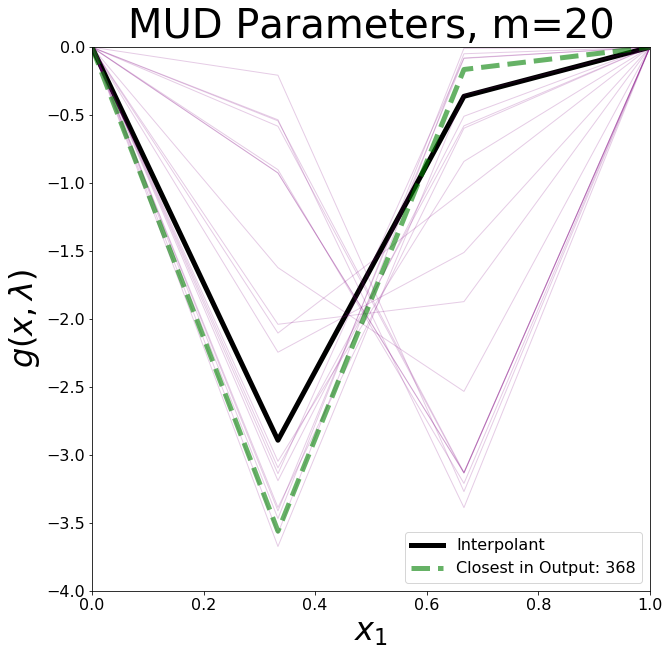

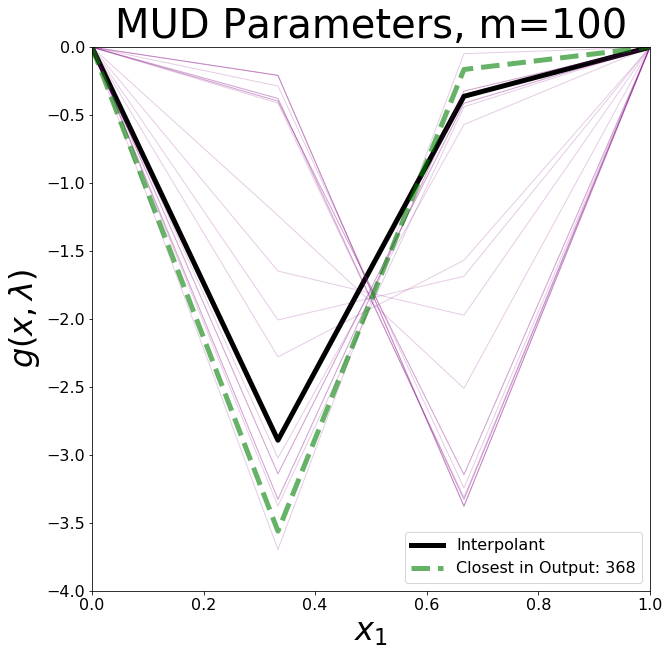

In [49]:
for num_plot_sensors in [20, 100]:
    plt.figure(figsize=(10,10))
    
    plt.subplot(111)
    plt.title(f'MUD Parameters, m={num_plot_sensors}', fontsize=1.25*fsize)
    plt.xlabel("$x_1$", fontsize=fsize)
    plt.ylabel("$g(x, \lambda)$", fontsize=fsize)
    plt.plot([0]+intervals+[1], [0]+ [w(i) for i in intervals] +[0], lw=5, c='k', label="Interpolant")
    for i in solutions_sing[num_plot_sensors]: # trials
        gt = lam[i,:]
        plt.plot([0]+intervals+[1], [0]+list(gt)+[0], lw=1, c='purple', alpha=0.2)
    gt = list(lam[closest_fit_index_out, :])
    plt.plot([0]+intervals+[1], [0]+gt+[0], lw=5, c='green', alpha=0.6, ls='--', label=f'Closest in Output: {closest_fit_index_out}')
    plt.ylim(-4, 0)
    plt.xlim(0, 1)
    plt.legend()
#     plt.subplot(122)
#     plt.title('Q-Q Plot', fontsize=1.25*fsize)
#     for i in solutions_sing[num_plot_sensors]: # trials
#         q = qoi[i,:]
#         plt.scatter(q[:num_plot_sensors], qoi_true[:num_plot_sensors] + noise[:num_plot_sensors],
#                     c='b', s=100, alpha=1.0/num_trials)
#         plt.plot(_a,_a, c='k', lw=3)
#         plt.ylabel('Collected Data', fontsize=fsize)
#         plt.xlabel('Predicted Data', fontsize=fsize)
#         plt.ylim(-0.5, 0.15)
#         plt.xlim(-0.5, 0.15)
#         plt.title(f'Solution {_r}, Index {_s}')
    _fname = f"{prefix}_pair_D{input_dim}-1_m{num_plot_sensors}.{ftype}"
    plt.savefig(_fname, bbox_inches='tight')
    plt.show()

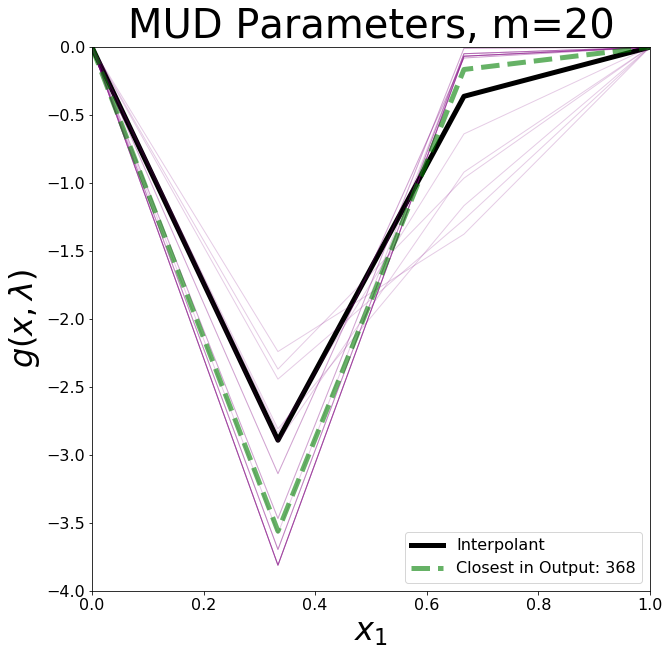

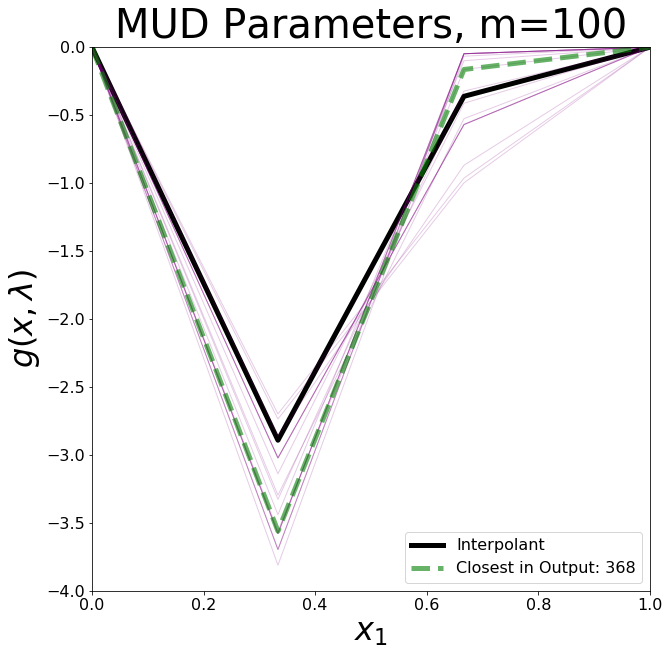

In [50]:
for num_plot_sensors in [20, 100]:
    plt.figure(figsize=(10,10))
    
    plt.subplot(111)
    plt.title(f'MUD Parameters, m={num_plot_sensors}', fontsize=1.25*fsize)
    plt.xlabel("$x_1$", fontsize=fsize)
    plt.ylabel("$g(x, \lambda)$", fontsize=fsize)
    plt.plot([0]+intervals+[1], [0]+ [w(i) for i in intervals] +[0], lw=5, c='k',label="Interpolant")
    for i in solutions_mult[num_plot_sensors]: # trials
        gt = lam[i,:]
        plt.plot([0]+intervals+[1], [0]+list(gt)+[0], lw=1, c='purple', alpha=0.2)
    gt = list(lam[closest_fit_index_out, :])
    plt.plot([0]+intervals+[1], [0]+gt+[0], lw=5, c='green', alpha=0.6, ls='--', label=f'Closest in Output: {closest_fit_index_out}')
    plt.ylim(-4, 0)
    plt.xlim(0, 1)
    plt.legend()
#     plt.subplot(122)
#     plt.title('Q-Q Plot', fontsize=1.25*fsize)
#     for i in solutions_mult[num_plot_sensors]: # trials
#         q = qoi[i,:]
#         plt.scatter(q[:num_plot_sensors], qoi_true[:num_plot_sensors] + noise[:num_plot_sensors],
#                     c='b', s=100, alpha=1.0/num_trials)
#         plt.plot(_a,_a, c='k', lw=3)
#         plt.ylabel('Collected Data', fontsize=fsize)
#         plt.xlabel('Predicted Data', fontsize=fsize)
#         plt.ylim(-0.5, 0.15)
#         plt.xlim(-0.5, 0.15)
#     plt.title(f'Solution {_r}, Index {_s}')
    _fname = f"{prefix}_pair_D{input_dim}-{num_qoi}_m{num_plot_sensors}.{ftype}"
    plt.savefig(_fname, bbox_inches='tight')
    plt.show()

In [51]:
if not load:
    print("Saving")
    fname = f'{prefix}_summary_{input_dim}.pkl'
    pickle.dump({'sets': (lam, qoi), 'sols': (solutions_sing, solutions_mult), 'meas': measurements, 'noise': (noise, tolerance), 'stdv': sigma, 'true': (gamma_true, qoi_true), 'sens': sensors }, open(fname, 'wb'))

---

# Figure: Response Surface + Sensors

---

# Basis Testing

How well is our prior able to express functions in the target space?

In [65]:
assert 1 == 0

AssertionError: 

# Getting $L^2$ Errors

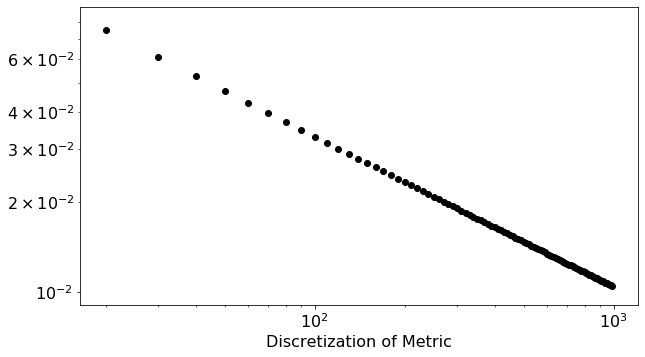

In [54]:
n = 1000
for i in range(20, n, 10):
    plt.scatter(i,expressionNorm(u,w,i), c='k')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Discretization of Metric")
plt.Axes.set_aspect(plt.gca(), 1)
plt.show()

### $\ell^2$ errors and $L^2$ errors

In [55]:
%%time
random_signals = [ fin.Expression(pcwGFun(randomsamples[:,r], d=0), degree=2) for r in range(nk) ]

NameError: name 'nk' is not defined

In [56]:
%%time
ell_2_error_initial = [ expressionNorm(u,r,100) for r in random_signals]

NameError: name 'random_signals' is not defined

In [57]:
%%time
error_initial = [np.linalg.norm(randomsamples[:,r] - gamma_true)/input_dim for r in range(nk) ]

NameError: name 'nk' is not defined

In [58]:
min_r = randomsamples[:, np.argmin(ell_2_error_initial)] 

NameError: name 'randomsamples' is not defined

In [ ]:
plt.hist(np.array(ell_2_error_initial), bins=20, label='$L^2$', density=True)
plt.hist(error_initial, bins=20, alpha=0.4, label='$\ell^2$', density=True)
plt.title("Error for Initial Functions")
plt.legend()
plt.show()

In [ ]:
min(error_initial), min(ell_2_error_initial)

In [ ]:
plt.scatter(error_initial, ell_2_error_initial)
plt.title("Metrics closely correlated despite\nradically different computational complexities")
plt.ylabel('$L^2$')
plt.xlabel('$\ell^2$')
plt.show()

In [ ]:
from scipy.stats import distributions as ds

In [ ]:
plt.hist(ds.invgauss.rvs(mu=1, size=(nk,)))

In [ ]:
%%time
nk = int(1E4)
# randomsamples = np.vstack([np.random.randn(nk) for _ in range(input_dim)])
# randomsamples = np.vstack([-ds.invgauss.rvs(mu=1, size=(nk,)) for _ in range(input_dim)])
randomsamples = np.vstack([ds.uniform.rvs(loc=-4, scale=4, size=(nk,)) for _ in range(input_dim)])


error_initial = [np.linalg.norm(randomsamples[:,r] - gamma_true)/input_dim for r in range(nk) ]
min_r = randomsamples[:, np.argmin(error_initial)]
plt.plot(np.linspace(0,1,input_dim+2)[1:-1],
            min_r,
            alpha=1, c='k')
plt.xlim(0,1)
plt.ylim(-4,0)
plt.scatter(intervals, gamma_true, marker='^', s=200, c='purple', zorder=10)
plt.show()

In [ ]:
a = np.argsort(error_initial)

In [ ]:
ns = 100
for i in range(ns):
    min_r = randomsamples[:, a[i]]
    plt.plot(np.linspace(0,1,input_dim+2)[1:-1], min_r,
                alpha=10/ns, c='k')
plt.scatter(intervals, gamma_true, marker='^', s=200, c='purple', zorder=10)
plt.show()

---

In [ ]:
fname = f'{prefix}_summary_{input_dim}.pkl'
print(fname)
results = pickle.load(open(fname, 'rb'))
solutions = results['sols']
measurements = results['meas']
sigma = results['noise']
lam, qoi = results['sets']
gamma_true, qoi_true = results['true']

In [ ]:
%%time
means_in, variances_in = extract_statistics_index(lam, solutions, gamma_true)
means_out, variances_out = extract_statistics_index(qoi, solutions, qoi_true)

In [ ]:
regression_mean, slope_mean = log_linear_regression(measurements, means_out)
regression_vars, slope_vars = log_linear_regression(measurements, variances_out)

## Output Error

In [59]:
_prefix = prefix
linewidth=5
means = means_out
variances = variances_out
test = True

NameError: name 'means_out' is not defined

In [60]:
xlabel = 'Number of Measurements'
plt.plot(measurements, regression_mean, label=f"{_prefix:10s}slope: {slope_mean:1.4f}", lw=linewidth)
plt.scatter(measurements, means, marker='x', lw=20)
plt.xscale('log')
plt.yscale('log')
plt.Axes.set_aspect(plt.gca(), 1)
plt.ylim(0.9*min(means), 1.3*max(means))
plt.xlabel(xlabel, fontsize=fsize)
plt.legend()
# plt.ylabel('$\\frac{1}{m}||Q(\lambda^\dagger) - Q(\lambda^{MUD}||$', fontsize=fsize)
plt.title(f"RMS Error (Mean)", fontsize=1.25*fsize)
plt.ylabel('$\\frac{1}{m}||Q(\lambda^\dagger) - Q(\lambda^{MUD})||$', fontsize=fsize)
if not test: plt.savefig(f'{prefix}_convergence_mud_obs_mean.pdf', bbox_inches='tight')
plt.show()

NameError: name 'regression_mean' is not defined

In [61]:
plt.figure(figsize=(10,10))
# regression_mean, slope_mean, regression_vars, slope_vars, means, variances = _rm
plt.plot(measurements, regression_vars, label=f"{_prefix:10s}slope: {slope_vars:1.4f}", lw=linewidth)
plt.scatter(measurements, variances, marker='x', lw=20)
plt.xscale('log')
plt.yscale('log')
plt.Axes.set_aspect(plt.gca(), 1)
plt.ylim(0.9*min(variances), 1.3*max(variances))
plt.xlabel(xlabel, fontsize=fsize)
plt.legend()
plt.ylabel('$\\frac{1}{m}||Q(\lambda^\dagger) - Q(\lambda^{MUD})||$', fontsize=fsize)
plt.title(f"RMS Error (Variance)", fontsize=1.25*fsize)
if not test: plt.savefig(f'{prefix}_convergence_mud_obs_var.pdf', bbox_inches='tight')
plt.show()

NameError: name 'regression_vars' is not defined

<Figure size 720x720 with 0 Axes>

## Input Error

In [62]:
_prefix = prefix
linewidth=5
means = means_in
variances = variances_in
test = True
regression_mean, slope_mean = log_linear_regression(measurements, means_in)
regression_vars, slope_vars = log_linear_regression(measurements, variances_in)

NameError: name 'means_in' is not defined

In [63]:
xlabel = 'Number of Measurements'
plt.plot(measurements, regression_mean, label=f"{_prefix:10s}slope: {slope_mean:1.4f}", lw=linewidth)
plt.scatter(measurements, means, marker='x', lw=20)
plt.xscale('log')
plt.yscale('log')
plt.Axes.set_aspect(plt.gca(), 1)
plt.ylim(0.9*min(means), 1.3*max(means))
plt.xlabel(xlabel, fontsize=fsize)
plt.legend()
# plt.ylabel('$\\frac{1}{m}||Q(\lambda^\dagger) - Q(\lambda^{MUD}||$', fontsize=fsize)
plt.title(f"RMS Error (Mean)", fontsize=1.25*fsize)
plt.ylabel('$\\frac{1}{p}||\lambda^\dagger - \lambda^{MUD}||$', fontsize=fsize)
if not test: plt.savefig(f'{prefix}_convergence_mud_obs_mean.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,10))
# regression_mean, slope_mean, regression_vars, slope_vars, means, variances = _rm
plt.plot(measurements, regression_vars, label=f"{_prefix:10s}slope: {slope_vars:1.4f}", lw=linewidth)
plt.scatter(measurements, variances, marker='x', lw=20)
plt.xscale('log')
plt.yscale('log')
plt.Axes.set_aspect(plt.gca(), 1)
plt.ylim(0.9*min(variances), 1.3*max(variances))
plt.xlabel(xlabel, fontsize=fsize)
plt.legend()
plt.ylabel('$\\frac{1}{p}||\lambda^\dagger - \lambda^{MUD}||$', fontsize=fsize)
plt.title(f"RMS Error (Variance)", fontsize=1.25*fsize)
if not test: plt.savefig(f'{prefix}_convergence_mud_obs_var.pdf', bbox_inches='tight')
plt.show()

NameError: name 'regression_mean' is not defined

---
## Tolerances (Not of Interest)

In [64]:
# ##########

# num_sensors = min(100, num_measure)

# sd_means, sd_vars = experiment_equipment(num_trials=num_trials,
#                                       num_measure=num_sensors,
#                                       sd_vals=sd_vals,
#                                       reference_value=lam_true,
#                                       fun=mud_wrapper)
# #
# regression_err_mean, slope_err_mean = log_linear_regression(tolerances, sd_means)
# regression_err_vars, slope_err_vars = log_linear_regression(tolerances, sd_vars)

# _in = (lam, qoi, sensors, qoi_true, experiments, solutions)
# _rm = (regression_mean, slope_mean, regression_vars, slope_vars, means, variances)
# _re = (regression_err_mean, slope_err_mean, regression_err_vars, slope_err_vars, sd_means, sd_vars, num_sensors)

In [ ]:
# from mud_problem import main_pde

In [ ]:
# model_list = l

In [ ]:
# res = main_pde(model_list, num_trials=5,
#              fsize=32,
#              seed=21,
#              lam_true=3.0,
#              domain=domain,
#              tolerances=tolerances,
#              measurements=num_measurements)